In [275]:
import matplotlib.pyplot as plt

dates = ['20120411', '20160413', '20200415', '20240410']

In [276]:
# 0: 극우
# 1: 보수
# 2: 중도
# 3: 진보
# 4: 극좌

def party_to_spectrum(date, party, city, name):
    f = open(f'election_change\\{date}-party.csv', 'r', encoding='UTF-8')
    result = []
    for line in f:
        line = line.split(',')

        if line[0] == party:
            if party != '무소속':
                result = list(map(int, line[3:]))
                break
            elif line[1] == city and line[2] == name:
                result = list(map(int, line[3:]))
                break
    
    f.close()
    return result

def get_party_color(spectrums: list[int]):
    if len(spectrums) == 0:
        return (0.5, 0.5, 0.5)
    colors = [(1, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 1, 0)]
    return colors[spectrums[0]]

In [277]:
def get_prev_district(date, city, district_name):
    prev_file = open(f'election_change\\{date}-district.csv', 'r')

    prev_city = city
    if date == '20240410':
        if city == '강원특별자치도':
            prev_city = '강원도'
        elif city == '전북특별자치도':
            prev_city = '전라북도'
        
    for line in prev_file:
        line = line.split(',')

        if line[0] == city and line[1] == district_name:
            result = []
            i = 2
            
            while i < len(line):
                if date == '20240410' and line[i] == '군위군의성군청송군영덕군':
                    prev_city = '경상북도'
                        
                result.append((prev_city, line[i], int(line[i + 1])))
                i += 2
            return result
        
    return [(prev_city, district_name, 1)]

In [278]:
data = []

for date in dates:
    election_file = open(f'election_data\\{date}-district.csv', 'r')
    election_data = {}
    party_set = set()

    for line in election_file:
        row = {}

        line = line.split(',')
        city = line[0]
        district_name = line[1].strip()

        if city not in election_data.keys():
            election_data[city] = {}

        idx = 2
        results = []

        while idx < len(line):
            party, name, votes = line[idx:idx+3]
            votes = float(votes)

            if votes >= 10:
                party_set.add(party)
                if party == '무소속':
                    print(f'{party},{city},{name}')

            results.append((party, name, votes))
            idx += 3
            
        election_data[city][district_name] = results
        if date == dates[0]:
            continue

    data.append(election_data)

무소속,서울특별시,유정현
무소속,서울특별시,정태근
무소속,서울특별시,김성식
무소속,서울특별시,김희철
무소속,부산광역시,정오규
무소속,부산광역시,이영
무소속,부산광역시,정근
무소속,부산광역시,최현돌
무소속,부산광역시,엄호성
무소속,부산광역시,최제완
무소속,부산광역시,박형준
무소속,대구광역시,이재용
무소속,대구광역시,오태동
무소속,대구광역시,최종탁
무소속,대구광역시,서중현
무소속,대구광역시,양명모
무소속,대구광역시,김충환
무소속,대구광역시,정기조
무소속,대구광역시,도이환
무소속,대구광역시,구성재
무소속,인천광역시,이윤성
무소속,광주광역시,양형일
무소속,광주광역시,이병훈
무소속,광주광역시,박주선
무소속,광주광역시,송갑석
무소속,광주광역시,조영택
무소속,광주광역시,정용화
무소속,광주광역시,강도석
무소속,광주광역시,김경진
무소속,광주광역시,김재균
무소속,울산광역시,김헌득
무소속,경기도,정미경
무소속,경기도,박주원
무소속,경기도,최영근
무소속,경기도,박정
무소속,경기도,박윤국
무소속,경기도,김문환
무소속,경기도,이희규
무소속,강원도,최연희
무소속,강원도,이화영
무소속,강원도,손문영
무소속,충청북도,심규철
무소속,전라북도,김광삼
무소속,전라북도,신건
무소속,전라북도,신영대
무소속,전라북도,채용묵
무소속,전라북도,박경철
무소속,전라북도,조배숙
무소속,전라북도,유성엽
무소속,전라북도,강광
무소속,전라북도,이남기
무소속,전라북도,이명노
무소속,전라북도,김만균
무소속,전라북도,김종규
무소속,전라남도,배종호
무소속,전라남도,김철주
무소속,전라남도,박종옥
무소속,전라남도,최인기
무소속,전라남도,신중식
무소속,전라남도,유인학
무소속,전라남도,윤재갑
무소속,전라남도,이영호
무소속,전라남도,한화갑
무소속,경상북도,최기복
무소속,경상북도,정장식
무소속,경상북도,박명재
무소속,경상북도,김석기
무소속,경상북도,김엽
무소속,경상북도,김경원
무소속,경상북도,최기문
무소속,경상북도,정송
무소속,경상북도,신현국
무소속,경상북도,이권우
무소속,경상북도,석호익
무소속,경상북도,김중권
무소속,경상남도,김병

In [279]:
def predict_prev_district(i, city, district_name):
    date = dates[i]
    prev_date = dates[i - 1]
    prev_districts = get_prev_district(date, city, district_name)

    # Get amount of votes that each spectrum got
    bucket = [0 for _ in range(5)]
    for (prev_city, prev_district, weight) in prev_districts:
        for (party, name, votes) in data[i - 1][prev_city][prev_district]:
            spectrums = party_to_spectrum(prev_date, party, prev_city, name)
            for s in spectrums:
                bucket[s] += weight * votes / len(spectrums)
    
    # Calculate how is the vote is going to be distributed, based on spectrum
    vote_dist = [[] for _ in range(5)]
    for candidate, (party, name, votes) in enumerate(data[i][city][district_name]):
        spectrums = party_to_spectrum(date, party, city, name)
        for s in spectrums:
            vote_dist[s].append((candidate, 1 / len(spectrums)))

    # Distribute the votes from the previous result to the result
    vote_prediction = [0 for _ in range(len(data[i][city][district_name]))]
    for s, dist_list in enumerate(vote_dist):
        weight_sum = sum(map(lambda x: x[1], dist_list))
        for (candidate, weight) in dist_list:
            vote_prediction[candidate] += weight / weight_sum * bucket[s]

    # Normalize the sum
    vote_sum = sum(vote_prediction)
    for n in range(len(vote_prediction)):
        vote_prediction[n] /= vote_sum / 100

    result = []
    for candidate, (party, name, votes) in enumerate(data[i][city][district_name]):
        prediction = vote_prediction[candidate]
        result.append((party, name, prediction))
    
    return result

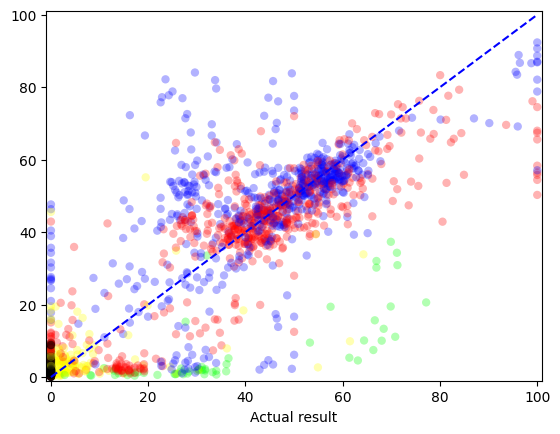

In [280]:
X = []
Y = []
colors = []
for i, date in enumerate(dates[2:]):
    i = i + 2
    for city in data[i].keys():
        for district_name in data[i][city].keys():
            prediction = predict_prev_district(i, city, district_name)
            result = data[i][city][district_name]

            colors.extend(map(lambda x: get_party_color(party_to_spectrum(date, x[0], city, x[1])), result))
            X.extend(map(lambda x: x[2], prediction))
            Y.extend(map(lambda x: x[2], result))

line = [x for x in range(101)]

plt.xlim(-1, 101)
plt.ylim(-1, 101)
plt.xlabel('Prediction')
plt.xlabel('Actual result')
plt.plot((0, 100), (0, 100), 'k--')
plt.scatter(X, Y, c=colors, alpha=0.3, edgecolors='none')